[Read more about SVMs by clicking here.](https://scikit-learn.org/stable/modules/svm.html)

Import locally required modules.

In [2]:
# Add local modules' path
# Restart notebook if you modify these imports' files
import os
import sys

module_path = os.path.abspath(os.path.join("..", "common"))

if module_path not in sys.path:
    sys.path.append(module_path)

# Actual imports
from common import kUtils

Get the split data.

In [3]:
import numpy as np # Used here only for the data type but extensively used later

X_train: np.ndarray; X_test: np.ndarray; X_val: np.ndarray; y_train: np.ndarray; y_test: np.ndarray; y_val: np.ndarray;

X_train, X_test, X_val, y_train, y_test, y_val = kUtils.get_split_data()

Set up the model and train it.

In [4]:
from sklearn.svm import SVC

model: SVC = SVC(kernel="linear", max_iter=5000) # Try out different kernels but, we're only interested in linear.

classifier: SVC = model.fit(X=X_train, y=y_train)

c:\Users\jalen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Metrics

Score: 0.9474285714285714
Accuracy: 0.9474285714285714
Mean squared error: 0.052571428571428575
Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      7020
         1.0       0.96      0.93      0.95      6980

    accuracy                           0.95     14000
   macro avg       0.95      0.95      0.95     14000
weighted avg       0.95      0.95      0.95     14000



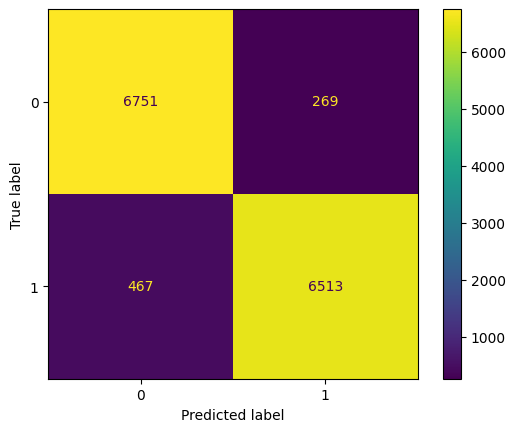

In [5]:
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred: np.ndarray = classifier.predict(X_test)

score: float = classifier.score(X=X_test, y=y_test)
accuracy: float = accuracy_score(y_true=y_test, y_pred=y_pred)
mse: float | np.ndarray = mean_squared_error(y_true=y_test, y_pred=y_pred)
c_report: str | dict = classification_report(y_true=y_test, y_pred=y_pred)
c_matrix: np.ndarray = confusion_matrix(y_true=y_test, y_pred=y_pred)

print("Score:", score)
print("Accuracy:", accuracy)
print("Mean squared error:", mse)
print("Classification report:\n", c_report)
# print("Confusion matrix:\n", c_matrix)
ConfusionMatrixDisplay(confusion_matrix=c_matrix).plot()

### Plotting the model

The high dimensional data can be reduced to a 2D representation through applying a PCA.

In [6]:
from sklearn.decomposition import PCA

pca: PCA = PCA(n_components=2)
X_pca: np.ndarray = pca.fit_transform(X_train) # For displaying points in this new layout
support_vectors_pca: np.ndarray = pca.transform(classifier.support_vectors_) # Used to display actual support vectors

The variance of the PCA is also important to note. It thankfully captures the data well.

In [7]:
explained_variance: np.ndarray = pca.explained_variance_ratio_ * 100
print(f"PC1 explains {explained_variance[0]:.2f}% of the variance")
print(f"PC2 explains {explained_variance[1]:.2f}% of the variance")
print(f"Variance explained by all principal components: {pca.explained_variance_ratio_.sum() * 100:.2f}%")

PC1 explains 98.58% of the variance
PC2 explains 0.31% of the variance
Variance explained by all principal components: 98.89%


Let's set up our points to plot.

In [8]:
h: float; x_min: float; x_max: float; y_min: float; y_max: float;

h = 0.02
x_min, x_max = X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1
y_min, y_max = X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1

xx: np.ndarray; yy: np.ndarray; zz: np.ndarray;

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

In order for our PCA plot to correctly show our model's output we have to predict our outputs in this new space and then reshape the predicted outputs to align with the axis.

In [9]:
y_pred: np.ndarray = classifier.decision_function(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
zz_distances: np.ndarray = y_pred.reshape(xx.shape)
zz = (zz_distances > 0)

Let's set up our visual boundaries, which should make the distinction between points much clearer.

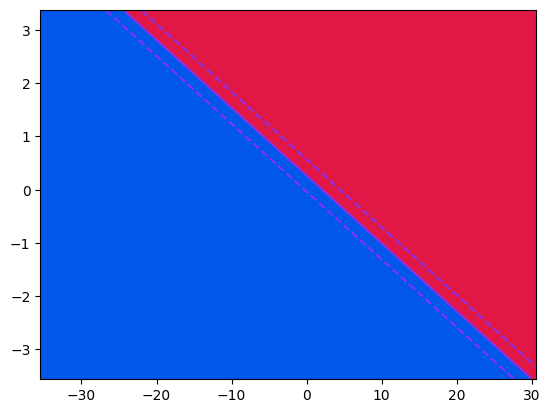

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from sklearn.inspection import DecisionBoundaryDisplay

# ---- Styling ----
# from matplotlib import colormaps, colors
from matplotlib.colors import ListedColormap
from matplotlib.contour import QuadContourSet
# print(colormaps)
# print(colors.cnames)
HIGH_RISK_COLOR: str = "#E11845"
LOW_RISK_COLOR: str = "#0057E9"
EDGE_COLOR: str = "#87E911"
LABEL_LINE_COLOR: str = "#8931EF"
LABEL_TEXT_COLOR: str = "#F2CA19"

split_color_map: ListedColormap = ListedColormap([LOW_RISK_COLOR, HIGH_RISK_COLOR])

# ---- End Styling ----

fig: Figure; ax: plt.Axes;

fig, ax = plt.subplots()

ax.contour(xx, yy, zz_distances, levels=[0], colors=LABEL_LINE_COLOR, linestyles="-")  # Decision boundary
ax.contour(xx, yy, zz_distances, levels=[-1, 1], colors=LABEL_LINE_COLOR, linestyles="--")  # Margins

dbd: DecisionBoundaryDisplay = DecisionBoundaryDisplay(
    xx0=xx,
    xx1=yy,
    response=zz,
)

dbd.plot(plot_method="pcolormesh", ax=ax, cmap=split_color_map)

Time to plot it all together!

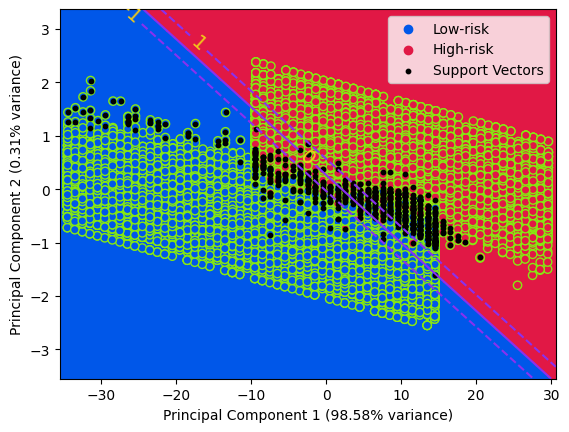

In [11]:
plt.contourf(xx, yy, zz, cmap=split_color_map)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap=split_color_map, edgecolors=EDGE_COLOR)
plt.scatter([], [], color=LOW_RISK_COLOR, label="Low-risk")
plt.scatter([], [], color=HIGH_RISK_COLOR, label="High-risk")

plt.scatter(support_vectors_pca[:, 0], support_vectors_pca[:, 1], facecolors="black", s=10, label="Support Vectors")

contourSet: QuadContourSet = plt.contour(xx, yy, zz_distances, levels=[0], colors=LABEL_LINE_COLOR, linestyles="-")  # Decision boundary
plt.clabel(contourSet, inline=1, colors=LABEL_TEXT_COLOR, fontsize="x-large")
contourSet = plt.contour(xx, yy, zz_distances, levels=[-1, 1], colors=LABEL_LINE_COLOR, linestyles="--")  # Margins
plt.clabel(contourSet, inline=1, colors=LABEL_TEXT_COLOR, fontsize="x-large")

plt.xlabel(f'Principal Component 1 ({explained_variance[0]:.2f}% variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1]:.2f}% variance)')
# plt.title('SVM Decision Boundary for Heart Attack Risk (PCA-Reduced from 18D)')
plt.legend()
plt.show()

### Additional Metrics

The features sorted by most indicative of a heart attack.

In [12]:
import pandas as pd

feature_list: list[str] = kUtils.get_feature_list()

feature_importance: pd.DataFrame = pd.DataFrame(
    pca.components_,
    columns=[feature_list[i] for i in range(len(X_train[0,]))],
    index=['PC1', 'PC2'],
)
feature_importance = feature_importance.sort_values(by=["PC1", "PC2"], axis="columns", ascending=False)

print("Feature Contributions to Principal Components:\n", feature_importance.T)

Feature Contributions to Principal Components:
                           PC1       PC2
Age                  0.999273 -0.038095
Cold_Sweats_Nausea   0.011313  0.282479
Pain_Arms_Jaw_Back   0.011227  0.281011
Shortness_of_Breath  0.011155  0.284218
Chest_Pain           0.011099  0.278263
Swelling             0.011080  0.283177
Dizziness            0.011055  0.284454
Palpitations         0.011007  0.286610
Fatigue              0.011006  0.283960
Chronic_Stress       0.007524  0.206883
Sedentary_Lifestyle  0.007513  0.201202
High_Cholesterol     0.007462  0.204393
Obesity              0.007349  0.209829
High_BP              0.007335  0.204049
Smoking              0.007326  0.204730
Family_History       0.007281  0.202640
Diabetes             0.007073  0.200184
Gender               0.005643  0.154662


Let's validate our model.

Score: 0.9468571428571428
Accuracy: 0.9468571428571428
Mean squared error: 0.053142857142857144
Classification report:
               precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     10477
         1.0       0.96      0.94      0.95     10523

    accuracy                           0.95     21000
   macro avg       0.95      0.95      0.95     21000
weighted avg       0.95      0.95      0.95     21000

Confusion matrix:
 [[10028   449]
 [  667  9856]]


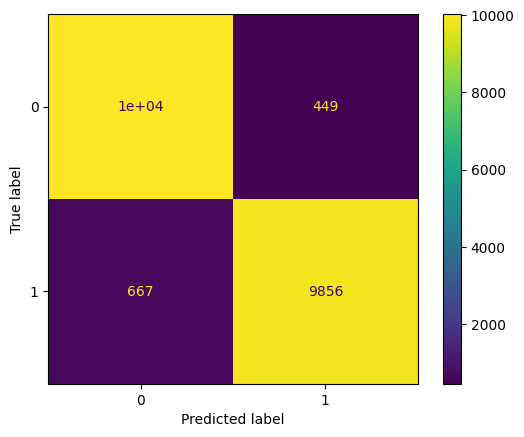

In [14]:
y_pred: np.ndarray = classifier.predict(X_val)

score: float = classifier.score(X=X_val, y=y_val)
accuracy: float = accuracy_score(y_true=y_val, y_pred=y_pred)
mse: float | np.ndarray = mean_squared_error(y_true=y_val, y_pred=y_pred)
c_report: str | dict = classification_report(y_true=y_val, y_pred=y_pred)
c_matrix: np.ndarray = confusion_matrix(y_true=y_val, y_pred=y_pred)

print("Score:", score)
print("Accuracy:", accuracy)
print("Mean squared error:", mse)
print("Classification report:\n", c_report)
print("Confusion matrix:\n", c_matrix)
ConfusionMatrixDisplay(confusion_matrix=c_matrix).plot()